In [1]:
import arviz as az
import matplotlib.pyplot as plt

import pandas as pd
import numpy as onp
from scipy.interpolate import BSpline

from jax import lax, vmap
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import hpdi, print_summary
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, init_to_value
import numpyro.optim as optim

az.style.use("arviz-darkgrid")
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# Chapter 4 Practice

Problems are labeled Easy (E), Medium (M), and Hard (H).

#### 4E1. In the model definition below, which line is the likelihood?
- [x] $y_i \sim \text{Normal}(\mu, \sigma)$
- [ ] $\mu \sim \text{Normal}(0, 10)$
- [ ] $\sigma \sim \text{Exponential}(1)$

#### 4E2. In the model definition just above, how many parameters are in the posterior distribution?
- 2

#### 4E3. Using the model definition above, write down the appropriate form of Bayes’ theorem that includes the proper likelihood and priors.

$$ Pr(\mu,\sigma|y_i) = \frac{\Pi_i\text{Normal}(y_i|\mu,\sigma)\text{Normal}(\mu|0,10)\text{Exponential}(\sigma|1)}{\int\int\Pi_i\text{Normal}(y_i|\mu,\sigma)\text{Normal}(\mu|0,10)\text{Exponential}(\sigma|1)d\mu d\sigma} $$

#### 4E4. In the model definition below, which line is the linear model?
- [ ] $y_i \sim \text{Normal}(\mu, \sigma)$
- [x] $\mu_i = \alpha + \beta x_i $
- [ ] $\alpha \sim \text{Normal}(0, 10)$
- [ ] $\beta \sim \text{Normal}(0,1)$
- [ ] $\sigma \sim \text{Exponential}(2)$

#### 4E5. In the model definition just above, how many parameters are in the posterior distribution?
- 3

#### 4M1. For the model definition below, simulate observed y values from the prior (not the posterior).

$$\begin{matrix}
y_i &\sim \text{Normal}(\mu, \sigma)\\
\mu &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{Exponential}(1)
\end{matrix}$$

In [29]:
with numpyro.handlers.seed(rng=100):
    N = 10000
    mu = numpyro.sample("mu", dist.Normal(0, 10), sample_shape=(N,))
    sigma = numpyro.sample("sigma", dist.Exponential(1), sample_shape=(N,))
    y = numpyro.sample('y', dist.Normal(mu,sigma))

print_summary({"y":y}, 0.89, 0)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         y      0.04     10.09     -0.06    -16.08     16.02   9727.38      1.00



#### 4M2. Translate the model just above into a quap formula.

In [34]:
def model_4m2(y):
    mu = numpyro.sample("mu", dist.Normal(0, 10), sample_shape=(N,))
    sigma = numpyro.sample("sigma", dist.Exponential(1), sample_shape=(N,))
    y = numpyro.sample('y', dist.Normal(mu,sigma), obs=y)

#### 4M3. Translate the quap model formula below into a mathematical model definition.
y ~ dnorm( mu , sigma )  
mu <- a + b*x  
a ~ dnorm( 0 , 10 )  
b ~ dunif( 0 , 1 )  
sigma ~ dexp( 1 )

$$ Pr(\alpha,\beta,\sigma|y_i,x_i) = \frac{\Pi_i\text{Normal}\big(y_i|\mu=(\text{Normal}(\alpha|0,10)+ \text{Uniform}(\beta|0,1)\times x_i),\sigma \big)\text{Exponential}(\sigma|1)}{\int\int\int\Pi_i\text{Normal}\big(y_i|\mu=(\text{Normal}(\alpha|0,10)+ \text{Uniform}(\beta|0,1)\times x_i),\sigma \big)\text{Exponential}(\sigma|1)\;d\alpha\;d\beta\; d\sigma} $$

#### 4M4. A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

h ~ ( mu, sigma)  
mu = alpha + beta * year   
alpha ~ Normal(165, 10)  
beta ~ Log-Normal(0, 10)  
sigma ~ Exponential(0.05)  

Explanation:  
- Suppose this is sample of young adult
- alpha is the mean of height, as a Vietnamese, which is quite smaller than other countries. The mean should be around 160 -170.
- beta is slope for `year`, and it should be postive as taller as people get older, so i use log normal.
- sigma is positive, the rate of exponenial is inverse of scale, so 1/0.05 = 20, so height can be 145 or 185.

$$ Pr(\alpha,\beta,\sigma|h_i,y_i) = \frac{\Pi_i\text{Normal}\big(h_i|\mu=(\text{Normal}(\alpha|165,10)+ \text{Log-Normal}(\beta|0,1)\times y_i),\sigma \big)\text{Exponential}(\sigma|0.05)}{\int\int\int\Pi_i\text{Normal}\big(h_i|\mu=(\text{Normal}(\alpha|165,10)+ \text{Log-Normal}(\beta|0,1)\times y_i),\sigma \big)\text{Exponential}(\sigma|0.05)\;d\alpha\;d\beta\; d\sigma} $$

#### 4M5. Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?
No, as slope of weight is already positive.

#### 4M6. Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?
It means sigma <= 8. So sigma prior maybe exponential (rate =1/8 = 0.125)  
Let's try if it's true.

In [84]:
for rate in np.arange(0.1, 2, 0.1):
    samples = dist.Exponential(rate).sample(PRNGKey(10), (10000,))
    max_variance = np.max(samples)**2
    print("rate=", rate, "maxvar=", np.round(max_variance,2), end='')
    if max_variance > 64:
        print('-'*10, '> not accepted')
    else:
        print('-'*10, '> accepted')

rate= 0.1 maxvar= 15014.84---------- > not accepted
rate= 0.2 maxvar= 3753.71---------- > not accepted
rate= 0.3 maxvar= 1668.32---------- > not accepted
rate= 0.4 maxvar= 938.43---------- > not accepted
rate= 0.5 maxvar= 600.59---------- > not accepted
rate= 0.6 maxvar= 417.08---------- > not accepted
rate= 0.7 maxvar= 306.43---------- > not accepted
rate= 0.8 maxvar= 234.61---------- > not accepted
rate= 0.9 maxvar= 185.37---------- > not accepted
rate= 1.0 maxvar= 150.15---------- > not accepted
rate= 1.1 maxvar= 124.09---------- > not accepted
rate= 1.2 maxvar= 104.27---------- > not accepted
rate= 1.3 maxvar= 88.85---------- > not accepted
rate= 1.4 maxvar= 76.61---------- > not accepted
rate= 1.5 maxvar= 66.73---------- > not accepted
rate= 1.6 maxvar= 58.65---------- > accepted
rate= 1.7 maxvar= 51.95---------- > accepted
rate= 1.8 maxvar= 46.34---------- > accepted
rate= 1.9 maxvar= 41.59---------- > accepted


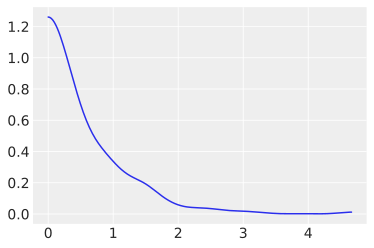

In [87]:
az.plot_dist(dist.Exponential(1.6).sample(PRNGKey(10), (1000,)))

-> I now choose prior for sigma ~ Exponential (1.6)